In [2]:
# Dau tien import 1 vai mothods, se su dung sau nay
from IPython.display import Image, HTML, display
# kiem tra pyspark chay
import spark
spark

<module 'spark' from '/home/taingo/.local/lib/python3.10/site-packages/spark/__init__.py'>

In [3]:
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col
from seaborn import *
import numpy as np
import tmdbsimple

### Load rating and movie data Tai du lieu rating va movie

**Ratings**

Du lieu ratings chua khoang 100,000 danh gia boi moi nguoi dung cho bo phim.Moi hang cua `DataFrame` chua `userid, `movieId` and `timestamp`

In [4]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RecommendationFilm") \
.getOrCreate()
    # .config("spark.driver.memory", "4g") \
    # .config("spark.executor.memory", "4g") \
    

# Specify the path to your CSV file
PATH_TO_DATA = "/home/taingo/Documents/ml-latest-small"

# Load ratings data using SparkSession
ratings = spark.read.csv(PATH_TO_DATA + "/ratings.csv", header=True, inferSchema=True)
ratings.cache()
print("So luong ratings: {}".format(ratings.count()))

ratings.show(5)

23/11/01 20:30:51 WARN Utils: Your hostname, taingo-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.85.129 instead (on interface ens33)
23/11/01 20:30:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/01 20:30:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


So luong ratings: 100836
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [5]:
# load raw data from CSV
raw_movies = spark.read.csv(PATH_TO_DATA + "/movies.csv", header=True, inferSchema=True)
print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))

raw_movies.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [8]:
import re
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

Nhận một tiêu đề phim (ví dụ: "Jumanji (1995)") làm đầu vào.

Sử dụng biểu thức chính quy để tìm và trích xuất năm phát hành từ tiêu đề. Trong ví dụ này, năm phát hành được tìm kiếm trong dấu ngoặc đơn và có định dạng bốn chữ số.

Loại bỏ năm phát hành từ tiêu đề ban đầu, để trả về tiêu đề đã được chỉnh sửa.

Trả về cả tiêu đề đã chỉnh sửa và năm phát hành đã trích xuất dưới dạng một cặp giá trị.


bay gio lam sach du lieu, viec lam sach lam sach nay giup co the hoat dong dc voi elasticsearch suon se

In [9]:
movies = raw_movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



Tiep theo, gop bang`links.csv` voi bang`movies`, voi id nay, co the su dung de import anh len goi la poster

In [10]:
link_data = spark.read.csv(PATH_TO_DATA + "/links.csv", header=True, inferSchema=True)
# join movies with links to get TMDB id
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, link_data.tmdbId)
num_movies = movie_data.count()
print("Lam sach du lieu voi tmdbId links:")
movie_data.show(5, truncate=False)

Lam sach du lieu voi tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+-------------------------------------------------+-

Successfully imported tmdbsimple!


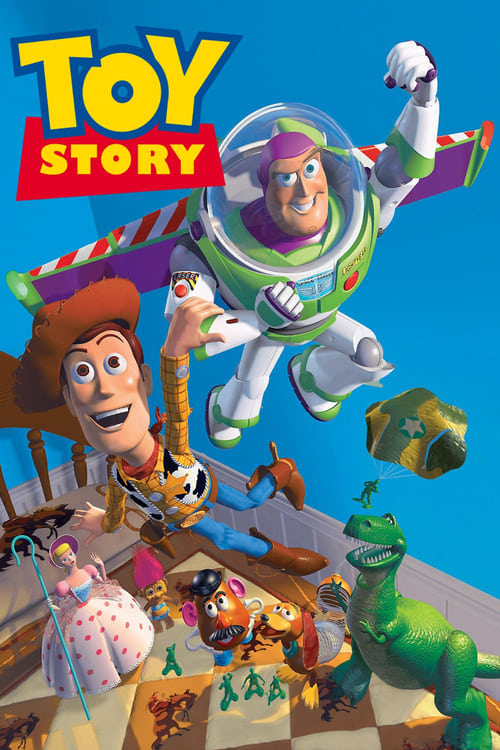

In [11]:
try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    tmdb.API_KEY = '6a1cf3f01fd70e17b5393ef1ba162909'
    print("Successfully imported tmdbsimple!")

    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))

Thanh Cong imported tmdbsimple!
Tên phim: Dancer in the Dark


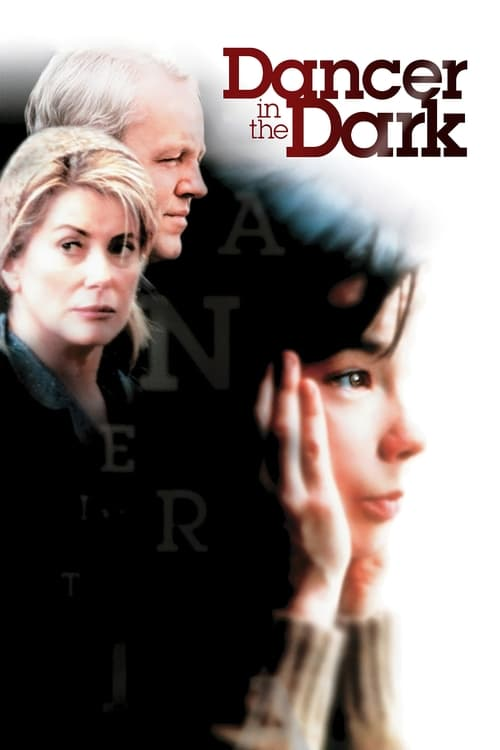

Tên phim: Ariel


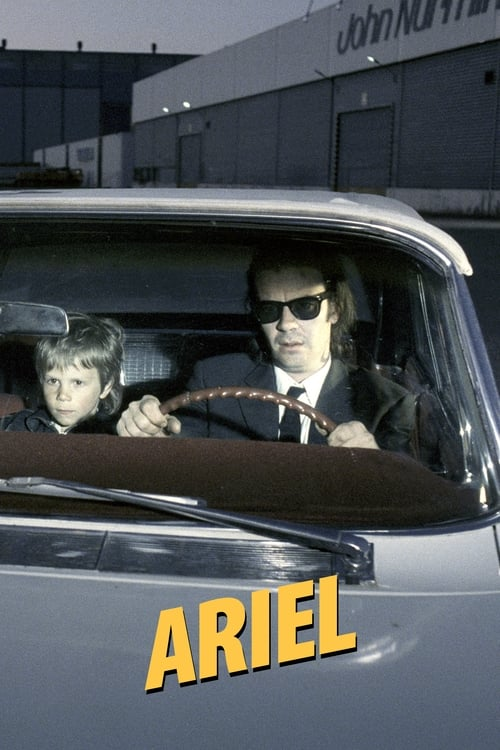

Tên phim: The Endless Summer


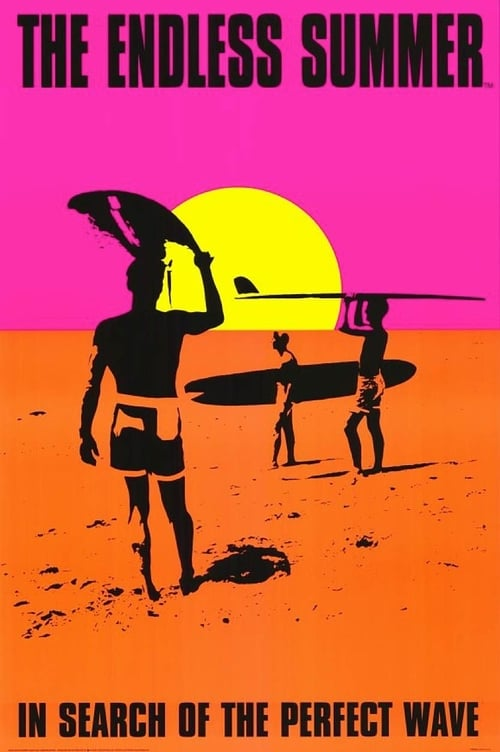

Tên phim: Star Wars


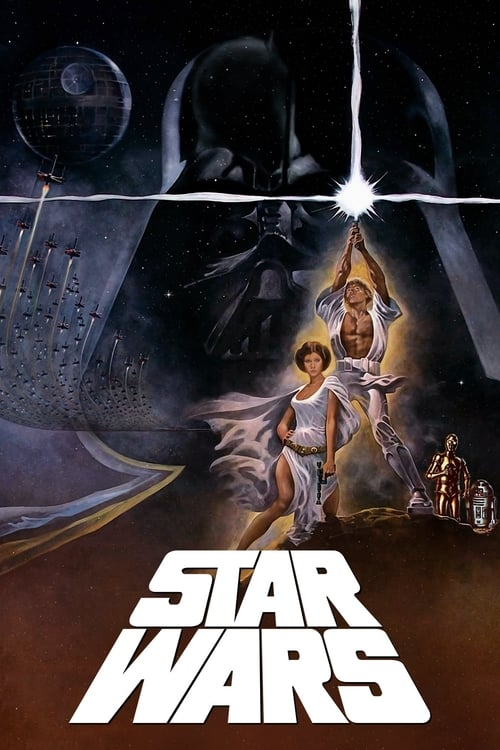

Tên phim: Walk the Line


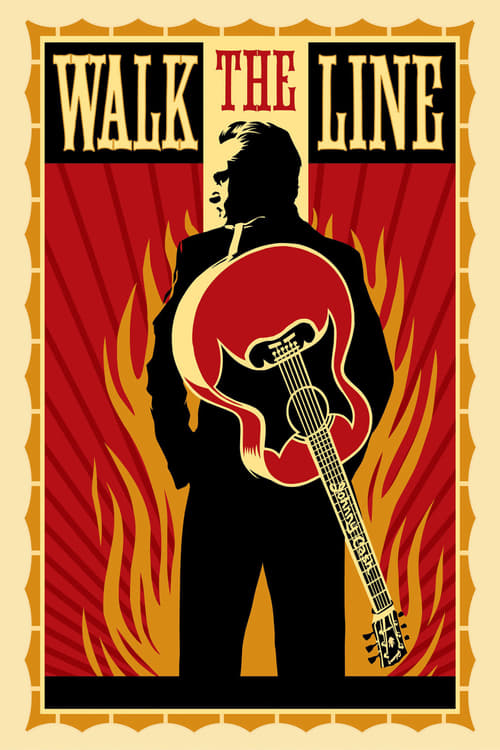

In [12]:
#  # Lấy tên của bộ phim
# movie_title = movie_info['title']
# movie_ids = [16, 2, 21, 11,69]
#   # Thay NEW_MOVIE_ID bằng id của bộ phim mới.
# movie_info = tmdb.Movies(movie_id).info()
#  for movie_id in movie_ids:
#         movie_info = tmdb.Movies(movie_id).info()
        
#         # Lấy tên của bộ phim
#         movie_title = movie_info['title']
        
#         # Lấy URL của ảnh bìa của bộ phim
#         movie_poster_url = IMAGE_URL + movie_info['poster_path']
        
#         # In tên của bộ phim
#         print("Tên phim:", movie_title)
# display(Image(movie_poster_url, width=200))

# #16, 2, 21, 11,69
try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    tmdb.API_KEY = '6a1cf3f01fd70e17b5393ef1ba162909'
    print("Thanh Cong imported tmdbsimple!")

    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'

    # Danh sách các ID của bộ phim bạn muốn xuất
    movie_ids = [16, 2, 21, 11, 69]

    for movie_id in movie_ids:
        movie_info = tmdb.Movies(movie_id).info()
        
        # Lấy tên của bộ phim
        movie_title = movie_info['title']
        
        # Lấy URL của ảnh bìa của bộ phim
        movie_poster_url = IMAGE_URL + movie_info['poster_path']
        
        # In tên của bộ phim
        print("Tên phim:", movie_title)
        
        # Hiển thị ảnh bìa của bộ phim
        display(Image(movie_poster_url, width=200))
    
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))


## Step 2: Load Du Lieu vao Elasticsearch

In [13]:
# from elasticsearch import Elasticsearch
# # test your ES instance is running
# es = Elasticsearch("http://localhost:9200")
# es.info(pretty=True)
from elasticsearch import Elasticsearch

# Create an Elasticsearch instance with the correct URL
es = Elasticsearch("http://localhost:9200")

# Test your ES instance is running and fetch information about the cluster
cluster_info = es.info(pretty=True)

# Print the cluster information
print(cluster_info)


{'name': 'taingo-virtual-machine', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'vBEsnH4oTdejS81kFlYmpw', 'version': {'number': '8.10.3', 'build_flavor': 'default', 'build_type': 'deb', 'build_hash': 'c63272efed16b5a1c25f3ce500715b7fddf9a9fb', 'build_date': '2023-10-05T10:15:55.152563867Z', 'build_snapshot': False, 'lucene_version': '9.7.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


### Tao Elasticsearch indices, Voi mappings cho users, movies va rating

__References:__
* [Tao index API](https://www.elastic.co/guide/en/elasticsearch/reference/current/indices-create-index.html)
* [Index mapping](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html)
* [Dense vector types](https://www.elastic.co/guide/en/elasticsearch/reference/current/dense-vector.html)

In [16]:
 es.indices.delete(index="ratings,users,movies") 
#Neu co ratings,users,movies thi xoa di 

ObjectApiResponse({'acknowledged': True})

In [17]:

VECTOR_DIM = 20

create_ratings = {

    "mappings": {
        "properties": {
            "timestamp": {
                "type": "date"
            },
            "userId": {
                "type": "integer"
            },
            "movieId": {
                "type": "integer"
            },
            "rating": {
                "type": "double"
            }
        }  
    }
}

create_users = {
    # this mapping definition sets up the metadata fields for the users
    "mappings": {
        "properties": {
            "userId": {
                "type": "integer"
            },
            # the following fields define our model factor vectors and metadata
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }
        }
    }
}

create_movies = {
    # this mapping definition sets up the metadata fields for the movies
    "mappings": {
        "properties": {
            "movieId": {
                "type": "integer"
            },
            "tmdbId": {
                "type": "keyword"
            },
            "genres": {
                "type": "keyword"
            },
            "release_date": {
                "type": "date",
                "format": "year"
            },

            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }          
        }
    }
}


res_ratings = es.indices.create(index="ratings", body=create_ratings)
res_users = es.indices.create(index="users", body=create_users)
res_movies = es.indices.create(index="movies", body=create_movies)

print("Tao indices:")
print(res_ratings)
print(res_users)
print(res_movies)

Tao indices:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'ratings'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'users'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'movies'}


### Tai DataFrames Ratings va Movies vao Elasticsearch

Dau tien se viet du lieu ratings vao Elasticsearch

In [18]:
# # write ratings data
# ratings.write.format("es").save("ratings")
# num_ratings_es = es.count(index="ratings")['count']
# num_ratings_df = ratings.count()
# # check write went ok
# print("Dataframe count: {}".format(num_ratings_df))
# print("ES index count:  {}".format(num_ratings_es))
from elasticsearch import Elasticsearch

# Kết nối với Elasticsearch
es = Elasticsearch(["http://localhost:9200"])

# Lấy dữ liệu từ DataFrame dưới dạng danh sách từ điển (dict)
data = ratings.rdd.map(lambda row: row.asDict()).collect()

# Ghi dữ liệu vào Elasticsearch
for doc in data:
    es.index(index="ratings", body=doc)

# Kiểm tra số lượng bản ghi trong Elasticsearch
num_ratings_es = es.count(index="ratings")['count']
num_ratings_df = len(data)  # Số lượng bản ghi trong danh sách

# Kiểm tra kết quả
print("Dataframe count: {}".format(num_ratings_df))
print("ES index count:  {}".format(num_ratings_es))


Dataframe count: 100836
ES index count:  100836


In [19]:
# kiem tra moi thu bang cach lay mot vai tai lieu tuElasticsearch
es.search(index="ratings", q="*", size=3)

ObjectApiResponse({'took': 28, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'ratings', '_id': 'U-sni4sB8Vr7sItROdKp', '_score': 1.0, '_source': {'userId': 120, 'movieId': 1073, 'rating': 2.0, 'timestamp': 860070029}}, {'_index': 'ratings', '_id': 'VOsni4sB8Vr7sItROdK1', '_score': 1.0, '_source': {'userId': 120, 'movieId': 1210, 'rating': 5.0, 'timestamp': 860070182}}, {'_index': 'ratings', '_id': 'Vesni4sB8Vr7sItROdK-', '_score': 1.0, '_source': {'userId': 120, 'movieId': 1367, 'rating': 4.0, 'timestamp': 860070258}}]}})

Vì  đã lập chỉ mục dữ liệu sự kiện xếp hạng vào Elaticsearch nên  có thể sử dụng tất cả khả năng của công cụ tìm kiếm để truy vấn dữ liệu.

In [20]:
es.count(index="ratings", q="timestamp:[2018-01-01 TO 2018-02-01]")

ObjectApiResponse({'count': 0, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

viet mot bo phim metadata

In [22]:
# test things out by searching for movies containing "matrix" in the title
es.search(index="movies", q="title:matrix", size=3)

ObjectApiResponse({'took': 1, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}})

## Bước 3: Huấn luyện mô hình người giới thiệu về dữ liệu xếp hạng

### Xen kẽ các ô vuông nhỏ nhất

Bình phương tối thiểu xen kẽ (ALS) là một thuật toán cụ thể để giải một loại mô hình lọc cộng tác được gọi là [phân tích nhân tử ma trận (MF)](https://en.wikipedia.org/wiki/Matrix_decomposition). Ý tưởng cốt lõi của MF là biểu diễn xếp hạng dưới dạng _ma trận xếp hạng mục-người dùng_. Trong sơ đồ bên dưới, sẽ thấy ma trận này ở bên trái (với người dùng là _rows_ và phim là _columns_). Các mục trong ma trận này là xếp hạng do người dùng đưa ra cho phim.

In [18]:
ratings_from_es = spark.read.format("es").load("ratings")
ratings_from_es.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|      1|   4.0|2000-07-30 20:45:03|     1|
|      3|   4.0|2000-07-30 20:20:47|     1|
|      6|   4.0|2000-07-30 20:37:04|     1|
|     47|   5.0|2000-07-30 21:03:35|     1|
|     50|   5.0|2000-07-30 20:48:51|     1|
+-------+------+-------------------+------+
only showing top 5 rows



In [19]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.02, rank=VECTOR_DIM, seed=54)
model = als.fit(ratings_from_es)
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.13299428, 0.42...|
| 20|[0.2196542, -0.28...|
| 30|[-0.58235997, 0.1...|
| 40|[0.31613937, -0.2...|
| 50|[0.3011615, 0.112...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.6092093, 0.570...|
| 20|[0.12555358, -0.2...|
| 30|[0.9184103, 0.465...|
| 40|[0.40230548, 0.53...|
| 50|[0.56450856, 0.10...|
+---+--------------------+
only showing top 5 rows



### Bước 4: Xuất vectơ nhân tố người dùng và mục ALS sang Elaticsearch

Chúng ta có thể xuất trực tiếp vectơ hệ số mô hình sang Elaticsearch vì đây là một mảng và trườngdense_vector yêu cầu một mảng làm đầu vào.

Với mục đích minh họa, chúng tôi cũng sẽ xuất siêu dữ liệu mô hình (chẳng hạn như id mô hình Spark và dấu thời gian).

### Viết các vectơ nhân tố mô hình, phiên bản mô hình và dấu thời gian của mô hình vào Elaticsearch

In [20]:
from pyspark.sql.functions import lit, current_timestamp, unix_timestamp
ver = model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = model.itemFactors.select("id",\
                                         col("features").alias("model_factor"),\
                                         lit(ver).alias("model_version"),\
                                         ts.alias("model_timestamp"))
movie_vectors.show(5)
user_vectors = model.userFactors.select("id",\
                                        col("features").alias("model_factor"),\
                                        lit(ver).alias("model_version"),\
                                        ts.alias("model_timestamp"))
user_vectors.show(5)

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.6092093, 0.570...|ALS_b289ae1d349c|     1585732983|
| 20|[0.12555358, -0.2...|ALS_b289ae1d349c|     1585732983|
| 30|[0.9184103, 0.465...|ALS_b289ae1d349c|     1585732983|
| 40|[0.40230548, 0.53...|ALS_b289ae1d349c|     1585732983|
| 50|[0.56450856, 0.10...|ALS_b289ae1d349c|     1585732983|
+---+--------------------+----------------+---------------+
only showing top 5 rows

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.13299428, 0.42...|ALS_b289ae1d349c|     1585732983|
| 20|[0.2196542, -0.28...|ALS_b289ae1d349c|     1585732983|
| 30|[-0.58235997, 0.1...|ALS_b289ae1d349c|     1585732983|
| 40|[0.31613937, -0.2...|ALS_b289ae1d349c|     1585732983|
| 50|[0.3011615

In [21]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES, since you want to update new fields only
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("movies", mode="append")

In [22]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "index" write mode for ES, since you have not written to the user index previously
# - "append" write mode for Spark
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("users", mode="append")

### kiểm tra xem dữ liệu viết đã đúng chưa

Có thể tìm kiếm một bộ phim để xem liệu vectơ nhân tố mô hình có được viết chính xác hay không

In [23]:
# search for a particular sci-fi movie
es.search(index="movies", q="force awakens")['hits']['hits'][0]

{'_index': 'movies',
 '_type': '_doc',
 '_id': '122886',
 '_score': 10.524785,
 '_source': {'movieId': 122886,
  'title': 'Star Wars: Episode VII - The Force Awakens',
  'release_date': '2015',
  'genres': ['action', 'adventure', 'fantasy', 'sci-fi', 'imax'],
  'tmdbId': 140607,
  'model_timestamp': 1585732985,
  'model_version': 'ALS_b289ae1d349c',
  'model_factor': [0.18812202,
   0.7076669,
   -1.3437241,
   -0.3083917,
   0.31944987,
   0.45389917,
   -0.8027336,
   -0.66270983,
   1.2934446,
   -0.12376652,
   0.5889607,
   -0.12555946,
   -1.1881688,
   0.60742664,
   1.0457083,
   0.564867,
   0.89669603,
   1.1521518,
   -0.39917782,
   -2.687924],
  'id': 122886}}

## Step 5:đề xuất sử dụng Elasticsearch!

cần tạo một vài hàm tiện ích cho:

* Tìm nạp áp phích phim từ API TMdb (tùy chọn)
* Xây dựng Elaticsearch [truy vấn điểm tập lệnh cho các hàm vectơ](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-script-score-query.html#vector-functions) để tạo đề xuất từ mô hình nhân tố của bạn
* Cho một bộ phim, sử dụng truy vấn này để tìm những bộ phim giống với bộ phim đó nhất
* Cho một người dùng, sử dụng truy vấn này để tìm những bộ phim có xếp hạng dự đoán cao nhất, để giới thiệu cho người dùng
* Hiển thị kết quả dưới dạng bảng HTML trong Jupyter

In [24]:
from IPython.display import Image, HTML, display

def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def vector_query(query_vec, vector_field, q="*", cosine=False):
    """
    Xây dựng truy vấn điểm tập lệnh Elaticsearch bằng cách sử dụng các trường `dense_vector`
    
     Truy vấn điểm tập lệnh lấy tham số là vectơ truy vấn (dưới dạng danh sách Python)
    
     Thông số
     ----------
     query_vec : danh sách
         Vectơ truy vấn
     vector_field : str
         Tên trường trong tài liệu để chấm điểm `query_vec`
     q: str, tùy chọn
         Chuỗi truy vấn cho truy vấn tìm kiếm (mặc định: '*' để tìm kiếm trên tất cả các tài liệu)
     cosine: bool, tùy chọn
         Có tính toán giống cosin hay không. Nếu `False` thì tích số chấm được tính (mặc định: Sai)
     
     Lưu ý: Elaticsearch không thể xếp hạng điểm âm. Do đó, trong trường hợp tích số chấm, phép biến đổi sigmoid
     được áp dụng. Trong trường hợp độ tương tự cosin, 1.0 được cộng vào điểm. Trong cả hai trường hợp, tài liệu không có
     vectơ nhân tố bị bỏ qua bằng cách áp dụng điểm 0,0.
    
     Vectơ truy vấn được truyền vào sẽ là vectơ nhân tố người dùng (nếu tạo phim được đề xuất cho người dùng)
     hoặc vectơ nhân tố phim (nếu tạo phim tương tự cho một phim nhất định)
   
    """
    
    if cosine:
        score_fn = "doc['{v}'].size() == 0 ? 0 : cosineSimilarity(params.vector, '{v}') + 1.0"
    else:
        score_fn = "doc['{v}'].size() == 0 ? 0 : sigmoid(1, Math.E, -dotProduct(params.vector, '{v}'))"
       
    score_fn = score_fn.format(v=vector_field, fn=score_fn)
    
    return {
    "query": {
        "script_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script": {
                "source": score_fn,
                "params": {
                    "vector": query_vec
                }
            }
        }
    }
}


def get_similar(the_id, q="*", num=10, index="movies", vector_field='model_factor'):
    """
    cho một movie id, thực hiện truy vấn điểm tập lệnh đề xuất để tìm các phim tương tự,
     được xếp hạng theo cosine. trả về `num` giống nhất, ngoại trừ chính bộ phim.
    """
    response = es.get(index=index, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=True)
        results = es.search(index=index, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, users="users", movies="movies", vector_field='model_factor'):
    """
    cho moouser id, thực hiện truy vấn điểm tập lệnh đề xuất để tìm các phim tương tự,
     được xếp hạng theo độ tương tự cosine. Chúng tôi trả về `num` giống nhất, ngoại trừ chính bộ phim.
    """
    response = es.get(index=users, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=False)
        results = es.search(index=movies, body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, ratings="ratings", movies="movies"):
    """
    cho một user id, lấy các bộ phim được người dùng đó đánh giá, từ xếp hạng cao nhất đến thấp nhất.
    """
    response = es.search(index=ratings, q="userId:{}".format(the_id), size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=movies, _source_includes=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, users="users", movies="movies", ratings="ratings"):
    user, recs = get_user_recs(the_id, q, num, users, movies)
    user_movies = get_movies_for_user(the_id, num_last, ratings, movies)
    # check that posters can be displayed
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    # display the movies that this user has rated highly
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    # now display the recommended movies for the user
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, movies="movies"):
    """
    Hiển thị phim truy vấn, cùng với các phim tương tự và điểm giống, trong một bảng
    """
    movie, recs = get_similar(the_id, q, num, movies)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

đưa ra một số đề xuất.

### 5(a) Tìm phim tương tự cho một phim nhất định

Điểm giống này được tính từ các vectơ nhân tố mô hình cho mỗi phim. Hãy nhớ lại rằng mô hình ALS đã đào tạo trước đó là mô hình lọc collaborative, do đó hai bộ phim được người dùng đánh giá cao sẽ có xu hướng giống nhau hơn. Người ta thường sử dụng độ tương tự cosine của các vectơ nhân tố phim làm thước đo độ tương tự giữa hai phim [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) 

Bằng cách sử dụng sự tương đồng này, có thể hiển thị các đề xuất dọc theo dòng những người thích bộ phim này cũng thích những bộ phim này.


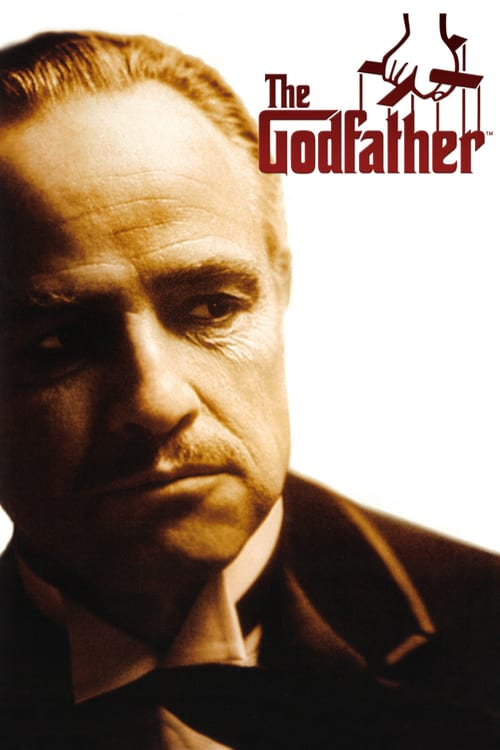

In [25]:
display_similar(858, num=5)

Elaticsearch cho phép điều chỉnh các kết quả được truy vấn đề xuất trả về bằng cách sử dụng bất kỳ truy vấn hoặc bộ lọc tìm kiếm tiêu chuẩn nào - từ tìm kiếm văn bản miễn phí cho đến các bộ lọc dựa trên thời gian và vị trí địa lý (hoặc bất kỳ phần siêu dữ liệu nào khác có thể nghĩ tới).
#### Lọc đề xuất dựa trên tiêu đề

Ví dụ: có lẽ bạn muốn xóa bất kỳ phim nào có tiêu đề "bố già" khỏi danh sách đề xuất. Bạn có thể thực hiện việc này bằng cách chuyển chuỗi truy vấn Elaticsearch hợp lệ tới hàm đề xuất.

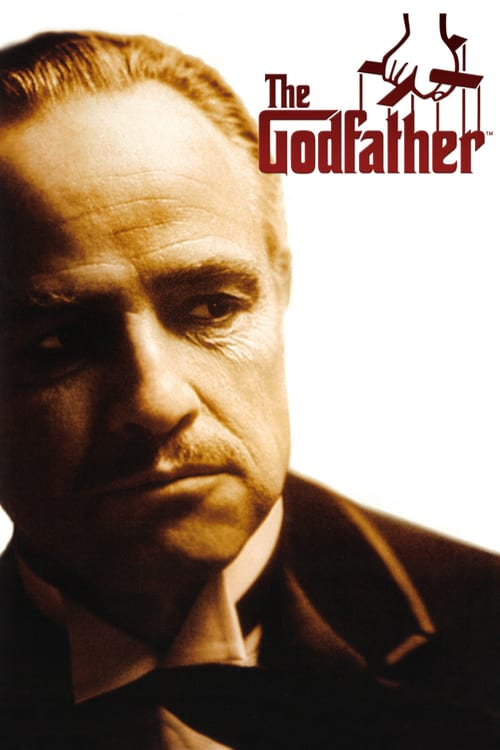

In [26]:
display_similar(858, num=5, q="title:(NOT godfather)")

Hiện tại chỉ có những bộ phim tương tự _không thuộc bộ ba Bố già_.

#### Lọc đề xuất dựa trên thể loại

đảm bảo chỉ những bộ phim hợp lệ dành cho trẻ em mới được chiếu cho khán giả nhỏ tuổi.

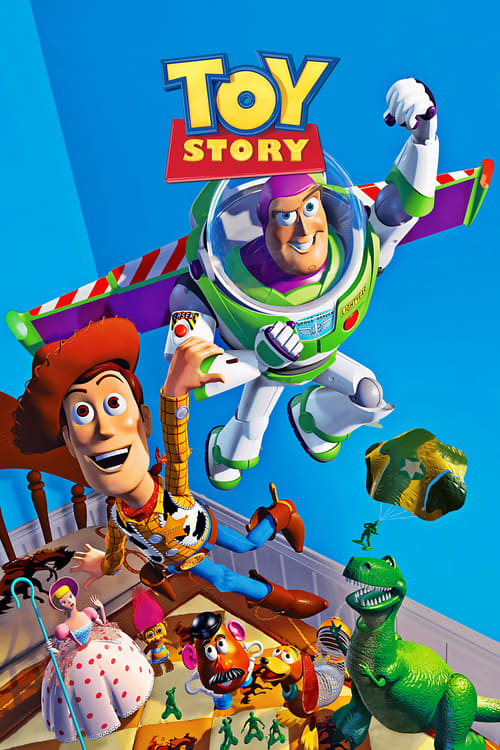

In [27]:
display_similar(1, num=5, q="genres:children")

Xem tài liệu về Elaticsearch [truy vấn chuỗi truy vấn](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-query-string-query.html) bạn có thể xây dựng bằng cách chuyển vào chuỗi truy vấn dưới dạng `q` trong hàm đề xuất ở trên.

### 5(b) Tìm phim để giới thiệu cho người dùng

Tạo một số đề xuất phim được cá nhân hóa cho một người dùng cụ thể.

Với một người dùng, có thể đề xuất phim cho người dùng đó dựa trên xếp hạng dự đoán từ mô hình. các đề xuất phim tương tự, điểm xếp hạng dự đoán này được tính từ vectơ nhân tố mô hình cho người dùng và vectơ nhân tố cho mỗi phim.

In [28]:
display_user_recs(72, num=5, num_last=5)

Again, note that since we are using a relatively small and sparse dataset, the results may not be too good. However, we can see that this user seems to like some sci-fi and some drama films. The recommended movies fall broadly into these categories and seem to be somewhat reasonable.

#### Filter recommendations based on release date

Next, you can again apply the power of Elasticsearch's filtering capabilities to your recommendation engine. Let's say you only want to recommend more recent movies (say, from the past 3 years). This can be done by adding a date math query to the recommendation function score query.

In [29]:
display_user_recs(72, num=5, num_last=5, q="release_date:[2017 TO *]")

You can see that the recommendation include only recent movies, again including mostly drama and sci-fi / fantasy titles.

As you did with the similar movies recommendations, feel free to play around with the various queries you could pass into the user recommendation query.